In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import math

In [3]:
h = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T123417_20240206T123957_32732_93_000001_20241120T170117.nc')
africa = h.groups['africa']

In [4]:
#RETRIEVE DATA AS VECTORS 
reflect = africa.variables['Reflectance'][0, :, 224, 271:471]
albd = africa.variables['surface_albedo'][0, :, 224]
sza = africa.variables['SZA'][0, :, 224]   
vza = africa.variables['VZA'][0, :, 224] 
spectchannel = africa.variables['spectral_channel'][271:471] 
transmittance = reflect/ albd[:, np.newaxis]
transmittance.shape

(406, 200)

In [5]:
# Convert data to torch tensors
R_tensor = torch.tensor(reflect, dtype=torch.float32)  # Already (406, 201), no need to reshape

# Expand vectors along second dimension (wavelength axis) so they match (406, 201)
a_tensor = torch.tensor(albd, dtype=torch.float32).unsqueeze(1).expand(-1, 200)
sza_tensor = torch.tensor(sza, dtype=torch.float32).unsqueeze(1).expand(-1, 200)
vza_tensor = torch.tensor(vza, dtype=torch.float32).unsqueeze(1).expand(-1, 200)
sc_tensor = torch.tensor(spectchannel, dtype=torch.float32).expand(406, -1)

In [6]:
class RadiativeTransferModel(nn.Module):
    def __init__(self): 
        super(RadiativeTransferModel, self).__init__()
        self.logTup  = nn.Linear(400, 200)   # For T^up, depends on arcos(mu) and lambda
        self.logTdown = nn.Linear(400, 200)  # For T^down, depends on arcos(mu0) and lambda
        
    def forward(self, sza, vza, spectchannel, albd):
        # Stack along second dimension so each input remains a feature
        input_up   = torch.cat([sza, spectchannel], dim=1)   
        input_down = torch.cat([vza, spectchannel], dim=1)   

        log_Tup   = self.logTup(input_up)    # Shape: (406, 201, 1)
        log_Tdown = self.logTdown(input_down)  # Shape: (406, 201, 1)

        # Remove extra dimension to match (406, 201)
        log_Tup = log_Tup.squeeze(-1)
        log_Tdown = log_Tdown.squeeze(-1)
        
        # Compute the predicted log(reflectance):
        log_R_pred = torch.log(albd) + log_Tup + log_Tdown
        R_pred = torch.exp(log_R_pred)
        return R_pred, log_R_pred, log_Tup, log_Tdown

In [7]:
model = RadiativeTransferModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss() 

In [8]:
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    R_pred, log_R_pred, log_Tup, log_Tdown = model(sza_tensor, vza_tensor, sc_tensor, a_tensor)
    
    # Compute loss (mean squared error between log-transformed reflectance values)
    log_R_true = torch.log(R_tensor)
    loss = criterion(log_R_pred, log_R_true)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
         print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 55504.816406
Epoch 100: Loss = 32.246212
Epoch 200: Loss = 1.256555
Epoch 300: Loss = 0.307110
Epoch 400: Loss = 0.061268
Epoch 500: Loss = 0.014898
Epoch 600: Loss = 0.008256
Epoch 700: Loss = 0.007521
Epoch 800: Loss = 0.007458
Epoch 900: Loss = 0.007453


In [9]:
vza_weights = model.logTup.weight[:, :200]  # Shape (200, 200)
spect_weights = model.logTup.weight[:, 200:]  # Shape (200, 200)
bias = model.logTup.bias  # Shape (200,)

(200, 1)

In [11]:
logTup = vza_weights.detach().numpy()@np.c_[africa.variables['VZA'][0,0:200,224].data] + spect_weights.detach().numpy()@np.c_[africa.variables['spectral_channel'][271:471]].data + np.c_[bias.detach().numpy()]
#Tup = np.exp(logTup)

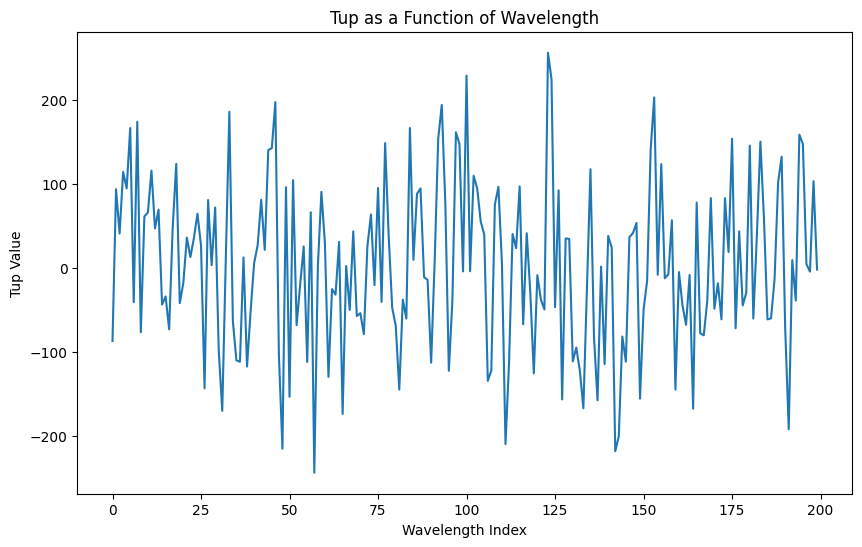

In [12]:
wavelengths = np.arange(200)  # Replace with actual wavelength values if available

plt.figure(figsize=(10, 6))
plt.plot(wavelengths, logTup, label='Tup')
plt.xlabel('Wavelength Index')
plt.ylabel('Tup Value')
plt.title('Tup as a Function of Wavelength')
plt.show()

In [13]:
sza_weights = model.logTdown.weight[:, :200]  # Shape (200, 200)
spect_weightsd = model.logTdown.weight[:, 200:]  # Shape (200, 200)
biasd = model.logTup.bias  # Shape (200,)
logTdown = sza_weights.detach().numpy()@np.c_[africa.variables['SZA'][0,0:200,224].data] + spect_weightsd.detach().numpy()@np.c_[africa.variables['spectral_channel'][271:471]].data + np.c_[biasd.detach().numpy()]

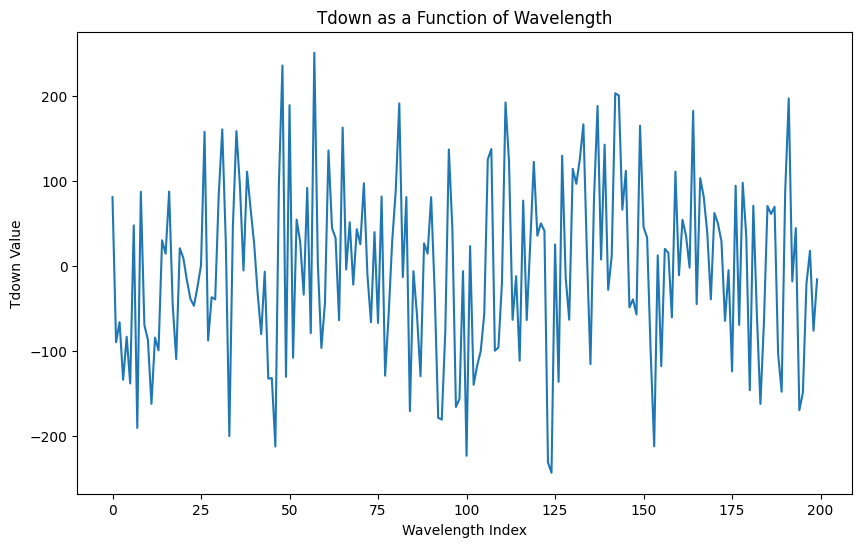

In [17]:
wavelengths = np.arange(200)  # Replace with actual wavelength values if available

plt.figure(figsize=(10, 6))
plt.plot(wavelengths, logTdown, label='Tup')
plt.xlabel('Wavelength Index')
plt.ylabel('Tdown Value')
plt.title('Tdown as a Function of Wavelength')
plt.show()

In [41]:
#computing sif
I = np.c_[africa.variables['Reflectance'][0, 100, 224, 271:471].data] - np.c_[africa.variables['surface_albedo'][0, 0:200, 224].data]@np.exp(logTup).transpose()@np.exp(logTdown)
#Not zero therefore not correct 
#
len(I)

200

In [82]:
#################################Attempt number 2

In [86]:
#transmitance data computed from before 

Epoch 0, Loss: 16.78384017944336
Epoch 1000, Loss: 0.020627718418836594
Epoch 2000, Loss: 0.00954204797744751
Epoch 3000, Loss: 0.0034162895753979683
Epoch 4000, Loss: 0.0013630622997879982
Epoch 5000, Loss: 0.0007714590174145997
Epoch 6000, Loss: 0.0014474557247012854
Epoch 7000, Loss: 0.0007111945888027549
Epoch 8000, Loss: 0.0007209187606349587
Epoch 9000, Loss: 0.0005445220158435404


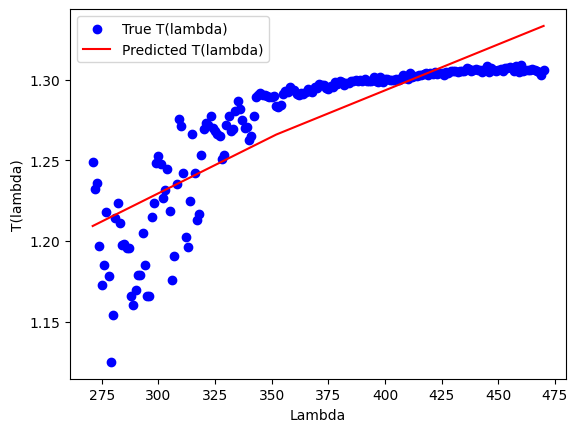

In [17]:
# Convert to PyTorch tensors
lambda_tensor = torch.tensor(spectchannel, dtype=torch.float32).view(-1, 1)
T_tensor = torch.tensor(transmitance, dtype=torch.float32).view(-1, 1)
#normalise so NN performs better 
#lambda_tensor = (lambda_tensor - lambda_tensor.mean()) / lambda_tensor.std()
#T_tensor = (T_tensor - T_tensor.mean()) / T_tensor.std()

# Define neural network
class T_Predictor(nn.Module):
    def __init__(self):
        super(T_Predictor, self).__init__()
        self.fc1 = nn.Linear(1, 50)  
        self.fc2 = nn.Linear(50, 50) 
        self.fc3 = nn.Linear(50, 50)  
        self.fc4 = nn.Linear(50, 1)  
        self.activation = nn.ReLU()  

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)  # No activation in output layer (regression problem)
        return x

# Initialize the model
model = T_Predictor()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(lambda_tensor)
    loss = criterion(predictions, T_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Make predictions
with torch.no_grad():
    T_pred = model(lambda_tensor)

#T_pred_denorm = T_pred * T_tensor.std() + T_tensor.mean()  # Convert back to original scale
#spectchannel_denorm = lambda_tensor * lambda_tensor.std() + lambda_tensor.mean()

# Plot results
import matplotlib.pyplot as plt
plt.scatter(spectchannel, transmitance, label="True T(lambda)", color="blue")
plt.plot(spectchannel, T_pred.numpy(), label="Predicted T(lambda)", color="red")
plt.xlabel("Lambda")
plt.ylabel("T(lambda)")
plt.legend()
plt.show()